# Average Path Length Distributions

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pickle, json, os, sys, csv, random, operator
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import utils
import netprop

## Load datasets

In [4]:
path = 'data/networks'
paths = [os.path.join(path, f) for f in os.listdir(path) if not f.startswith('.')]

networks = {}
for gpath in paths:
    fname = gpath.rsplit('/', 1)[-1].split('.')[0]
    networks[fname] = ig.Graph.Read_Pickle(gpath)
    print fname
    print networks[fname].summary()

acl
IGRAPH DN-- 18665 115311 -- 
+ attr: attributed (g), attributes (g), single_attr (g), attrs (v), id (v), name (v), single_attr (v), time (v), venue_id (v)


hepph
IGRAPH DN-- 30558 347228 -- 
+ attr: attributed (g), attributes (g), single_attr (g), month (v), name (v), time (v), year (v)


judicial
IGRAPH DN-- 30288 216738 -- 
+ attr: attributed (g), attributes (g), single_attr (g), name (v), time (v)


## Load APL data

In [5]:
def parse_path_length_data(fpath):
    """parse path length data and return apl distribution"""
    pl_counter = defaultdict(int)
    parse_line = lambda s: list(map(int, s.split(' ')))
    with open(fpath, 'r') as f:
        for line in f:
            nid, k, freq = parse_line(line)
            pl_counter[k] += freq
            
    total = float(sum(pl_counter.values()))
    xk, pk = zip(*sorted({k: v/total for k,v in pl_counter.items()}.items()))
    return xk, pk

## Visualize APL distributions

/ext/sage/sage-8.3_1804/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/ext/sage/sage-8.3_1804/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/ext/sage/sage-8.3_1804/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


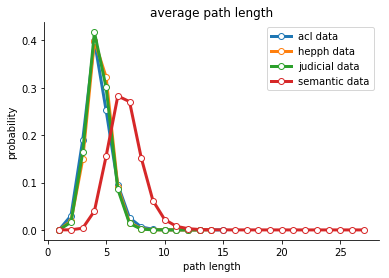

In [6]:
#ACL 
xk, pk = parse_path_length_data('data/path_length_outputs/acl.txt')
ax = plt.subplot()
ax.plot(xk, pk, label='acl data', marker='o', lw=3, mfc='w')
utils.update_ax(ax, 'average path length', 'path length', 'probability')

#hepph
xk, pk = parse_path_length_data('data/path_length_outputs/hepph.txt')
ax = plt.subplot()
ax.plot(xk, pk, label='hepph data', marker='o', lw=3, mfc='w')
utils.update_ax(ax, 'average path length', 'path length', 'probability')

#judicial
xk, pk = parse_path_length_data('data/path_length_outputs/judicial.txt')
ax = plt.subplot()
ax.plot(xk, pk, label='judicial data', marker='o', lw=3, mfc='w')
utils.update_ax(ax, 'average path length', 'path length', 'probability')

#semantic
xk, pk = parse_path_length_data('data/path_length_outputs/semantic.txt')
ax = plt.subplot()
ax.plot(xk, pk, label='semantic data', marker='o', lw=3, mfc='w')
utils.update_ax(ax, 'average path length', 'path length', 'probability')

